## Make a brighter-fatter kernel from a set of high-intensity flats for DC2.
Michael Wood-Vasey  (2018-09-29)

1. Set up a basic repo with the raw flats
2. Use `cp_pipe` `MakeBrighterFatterKernelTask` to construct a BF kernel
3. Visualize the kernels and compare PhoSim, ImSim, HSC, and lab-based ITL.

With substantial help from Merlin Fisher-Levine.

Jim Chiang kindly created a set of Phosim and ImSim flats at NERSC:

* ImSim flat pairs are `/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits`
  - ImSim visits are 161899, 161900
  - Gains are set to 1.7
* PhoSim flat pairs are `/global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits`.  
  - The visit numbers for these PhoSim flat pairs are 0..11.
  - Gains are set to 1.0.
  - There are three pairs in u at 70k, 80k, and 90k e-/pixel, and three pairs in i for the same signal levels.   Note that these are in the _ImSim_ `raw` format since the original PhoSim runs didn't generate the amplifier files, so it's not trivially easy to make PhoSim `raw` format images.  

Use `lsst.obs.lsstCam.ImsimMapper` for both on ingest.

Jim also made a set of ImSim flat pairs for R22_S11 for a sequence of signal levels, from 10k to 80k e-/pixel, in steps of 10k.  One might use these in the future to look at the full photon transfer curve ("non-linearity").  
`/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/ptc_dataset/lsst_a*.fits`  
These pairs can be identified by looking for the shorter `EXPTIME` values.

### Logistics

* Versions  
This was run through the JupyterLab environment at NERSC (https://jupyter-dev.nersc.gov) based on `w_2018_38`
but with a custom kernelspec that loaded a set of local checkouts of

```
obs_base tickets/DM-13293
obs_lsstCam tickets/DM-15509
cp_pipe tickets/DM-13293
```

file:///global/homes/w/wmwv/.local/share/jupyter/kernels/shifter-stack-obs-lsstCam  
file:/global/homes/w/wmwv/.local/share/jupyter/kernels/shifter-stack-obs-lsstCam/kernel.json  
file:/global/homes/w/wmwv/.local/share/jupyter/kernels/shifter-stack-obs-lsstCam/desc-stack-obs-lsstCam.sh


## References
* For an introduction to the brighter-fatter effect, see 
  - http://adsabs.harvard.edu/abs/2014JInst...9C3048A  Antilogous, Astier, Guyonnet, Regnault. 2014. JInst, 9, C3048.
* For a starting place for DESC thinking about brighter-fatter, see 
  - https://confluence.slac.stanford.edu/display/LSSTDESC/Brighter+Fatter+Effect   (DESC private page)
* See Andrew Bradshaw's [StackClub](https://github.com/LSSTScienceCollaborations/StackClub) notebook studying the brighter-fatter effect on stars and galaxies projected from the lab-based beam simulator.
  - [Rendered] http://nbviewer.jupyter.org/url/andrewnomy.com/sync/BrighterFatterCorrection.ipynb?flush_cache=true
  - [Raw] https://github.com/LSSTScienceCollaborations/StackClub/blob/project/beamsim/andrewkbradshaw/ImageProcessing/BrighterFatterCorrection.ipynb
* Analysis of Brighter-Fatter in DECam
  - http://adsabs.harvard.edu/abs/2015JInst..10C5032G  Gruen, Berstein, JArvis, Rowe, Vikram, Plazas, Seitz.  2015.  JInst, 10, C5032.

### DM-Free Inspection of BF kernels
If you just want to look at these without loading any DM environment, I've saved copies here in the DC2-production repo.  The stack-generated BF kernels are just 2D arrays as the value of a simple single-element dictionary where the key is the amp name.  You can just load them directly as:

* PhoSim  
```
bf_kernels/PhoSim/bfKernel-R22-S11-det094.pkl
```
* ImSim  
```
bf_kernels/ImSim/bfKernel-R01-S00-det000.pkl
bf_kernels/ImSim/bfKernel-R01-S01-det001.pkl
bf_kernels/ImSim/bfKernel-R01-S02-det002.pkl
bf_kernels/ImSim/bfKernel-R01-S10-det003.pkl
```
* HSC  
`bf_kernels/HSC/hsc_brighter_fatter_kernel.pkl`
* ITL (lab-based)  
`bf_kernels/Lab/BF_kernel-ITL_3800C_002.fits`  
The lab-based (ITL) BF kernel is a FITS file.  No dictionary, just a 2D array stored as a FITS image.

In [1]:
import os

import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
# Test to make sure that we can import obs_lsstCam
import lsst.obs.base
import lsst.obs.lsstCam

In [3]:
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask
from lsst.daf.persistence import Butler
from lsst.pipe.tasks.ingest import IngestTask

In [4]:
# Declare this explicitly just so we can use the cached versions of the output repos
# If you have trouble with permissions acessing this directory, please bug me (wmwv)
base_dir = '/global/u1/w/wmwv/local/lsst/DC2-production/Notebooks'

## Make PhoSim Brighter-Fatter Kernel

In [5]:
# Uncomment this `rm` command when you really mean to reingest, reprocess, and delete repo
! rm -rf phosim_repo

! mkdir phosim_repo
! echo "lsst.obs.lsstCam.LsstCamMapper" > phosim_repo/_mapper

# Ingest the PhoSim flats
! ingestImages.py phosim_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/phosim/bf_flats/lsst_a*.fits --mode link

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/phosim/bf_flats/lsst_a_000000_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo/raw/0/R22/00000000-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/phosim/bf_flats/lsst_a_000001_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo/raw/1/R22/00000001-R22-S11-det094-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/calibration_products/phosim/bf_flats/lsst_a_000002_R22_S11.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/phosim_repo/raw/2/R22/00000002-R22-S11-det094-000.fits
ingest INFO: /globa

In [6]:
# Set the gain values.
amp_names = ['C{:02d}'.format(i) for i in range(18)]
phosim_gain = 1.0
nominalGain = {a: phosim_gain for a in amp_names}

In [7]:
phosim_repo = os.path.join(base_dir, 'phosim_repo')
phosim_detector = 94
butler = Butler(phosim_repo)

In [8]:
gain = nominalGain
dataRef = butler.dataRef('brighterFatterGain', dataId={'detector': phosim_detector}) 
dataRef.put(gain, 'brighterFatterGain')   

Calculate the brighter-fatter kernel using `MakeBrighterFatterKernelTask`.  This will take ~10 minutes.

In [9]:
args = ['phosim_repo', '--rerun', 'test',
        '--id', 'detector={}'.format(phosim_detector),
        '--visit-pairs', '3,9', '4,8', '6,7',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=False',
        '--clobber-config', '--clobber-versions'
       ]

# In case you want to compare with running in terminal.
# Or perhaps you have access more easily to the stack version in a terminal than in a Jupyter kernel:
command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

phosim_pb_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py phosim_repo --rerun test --id detector=94 --visit-pairs 3,9 4,8 6,7 -c xcorrCheckRejectLevel=2 doCalcGains=False --clobber-config --clobber-versions


Unable to find ip_isr 16.0-9-gcc4efb7+15 although it is seen in the environment
Unable to find astshim 16.0-2-g0febb12+11 although it is seen in the environment
Unable to find pytest_forked 0.2.lsst4+2 although it is seen in the environment
Unable to find pex_policy 16.0-3-g404ea43+3 although it is seen in the environment
Unable to find jointcal 16.0-16-g925333c+3 although it is seen in the environment
Unable to find lsst_distrib 16.0+63 although it is seen in the environment
Unable to find ctrl_platform_lsstvc 15.0+43 although it is seen in the environment
Unable to find ctrl_orca 16.0-2-g2315192+2 although it is seen in the environment
Unable to find meas_extensions_photometryKron 16.0-5-g1991253+3 although it is seen in the environment
Unable to find display_ds9 16.0-2-g9d5294e+30 although it is seen in the environment
Unable to find meas_extensions_simpleShape 16.0-5-gb3f8a4b+35 although it is seen in the environment
Unable to find meas_algorithms 16.0-17-g6a7bfb3b+3 although it is

Ignore warnings.

### Look at the PhoSim BF Kernel
It worked.  let's load in the kernel and look at it!

In [18]:
test_phosim_repo = os.path.join(phosim_repo, 'rerun', 'test')
test_butler = Butler(test_phosim_repo)
phosim_bf_object = test_butler.get('brighterFatterKernel', dataId={'raftName': 'R22', 'detectorName': 'S11', 'detector': phosim_detector})
phosim_bf_kernel = phosim_bf_object.kernel

In [19]:
plt.imshow(phosim_bf_kernel[phosim_detector])

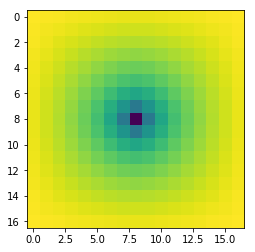

In [20]:
plt.show()

In [21]:
plt.plot(phosim_bf_kernel[phosim_detector][:,8], color='blue', drawstyle='steps-mid')
plt.plot(phosim_bf_kernel[phosim_detector][8,:], linestyle='--', color='red', drawstyle='steps-mid')

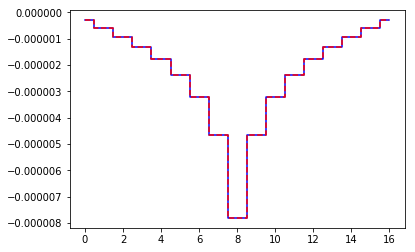

In [22]:
plt.show()

## Make ImSim Brighter-Fatter Kernel

In [23]:
# Uncomment this `rm` command when you really mean to reingest, reprocess, and delete repo
! rm -rf imsim_repo

! mkdir imsim_repo
! echo "lsst.obs.lsstCam.LsstCamMapper" > imsim_repo/_mapper

# Ingest the PhoSim flats
! ingestImages.py imsim_repo /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits --mode link

root INFO: Loading config overrride file '/global/homes/w/wmwv/local/lsst/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo
ingest INFO: /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_161899_R01_S00_r.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo/raw/161899/R01/00161899-R01-S00-det000-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_161899_R01_S01_r.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo/raw/161899/R01/00161899-R01-S01-det001-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_161899_R01_S02_r.fits --<link>--> /global/u1/w/wmwv/local/lsst/DC2-production/Notebooks/imsim_repo/raw/161899/R01/00161899-R01-S02-det002-000.fits
ingest INFO: /global/cscratch1/sd/jchiang8/desc/im

In [24]:
# Explicitly set the gain values.
amp_names = ['C{:02d}'.format(i) for i in range(18)]
imsim_gain = 1.7
nominalGain = {a: imsim_gain for a in amp_names}

In [25]:
imsim_repo = os.path.join(base_dir, 'imsim_repo')
butler = Butler('imsim_repo')

imsim_detectors = (0, 1, 2, 3)

gain = nominalGain
for det in imsim_detectors:
    dataRef = butler.dataRef('brighterFatterGain', dataId={'detector': det}) 
    dataRef.put(gain, 'brighterFatterGain')   

In [26]:
args = ['imsim_repo', '--rerun', 'test',
        '--id', 'detector=0..3',
        '--visit-pairs', '161899,161900',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=False',
        '--clobber-config', '--clobber-versions'
       ]

# In case you want to compare with running in terminal.
# Or perhaps you have access more easily to the stack version in a terminal than in a Jupyter kernel:
command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

imsim_pb_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py imsim_repo --rerun test --id detector=0..3 --visit-pairs 161899,161900 -c xcorrCheckRejectLevel=2 doCalcGains=False --clobber-config --clobber-versions


Unable to find ip_isr 16.0-9-gcc4efb7+15 although it is seen in the environment
Unable to find astshim 16.0-2-g0febb12+11 although it is seen in the environment
Unable to find pytest_forked 0.2.lsst4+2 although it is seen in the environment
Unable to find pex_policy 16.0-3-g404ea43+3 although it is seen in the environment
Unable to find jointcal 16.0-16-g925333c+3 although it is seen in the environment
Unable to find lsst_distrib 16.0+63 although it is seen in the environment
Unable to find ctrl_platform_lsstvc 15.0+43 although it is seen in the environment
Unable to find ctrl_orca 16.0-2-g2315192+2 although it is seen in the environment
Unable to find meas_extensions_photometryKron 16.0-5-g1991253+3 although it is seen in the environment
Unable to find display_ds9 16.0-2-g9d5294e+30 although it is seen in the environment
Unable to find meas_extensions_simpleShape 16.0-5-gb3f8a4b+35 although it is seen in the environment
Unable to find meas_algorithms 16.0-17-g6a7bfb3b+3 although it is

### Look at the ImSim BF Kernel
It worked.  let's load in the kernel and look at it!

In [27]:
test_imsim_repo = os.path.join(base_dir, 'imsim_repo', 'rerun', 'test')

test_butler = Butler(test_imsim_repo)
imsim_detectors = (0, 1, 2, 3)

In [29]:
imsim_bf_kernel = {}
for det in imsim_detectors:
    this_bf_object = test_butler.get('brighterFatterKernel', dataId={'detector': det})
    imsim_bf_kernel.update(this_bf_object.kernel)

In [30]:
print(imsim_bf_kernel.keys())

dict_keys([0, 1, 2, 3])


In [32]:
plt.imshow(imsim_bf_kernel[0])
plt.imshow(imsim_bf_kernel[1])
plt.imshow(imsim_bf_kernel[2])
plt.imshow(imsim_bf_kernel[3])

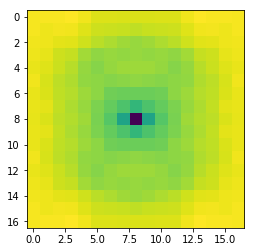

In [32]:
plt.show()

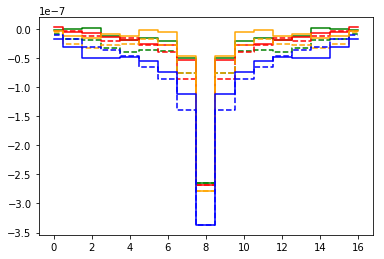

In [35]:
plt.plot(imsim_bf_kernel[0][:,8], color='green', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[0][8,:], color='green', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[1][:,8], color='red', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[1][8,:], color='red', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[2][:,8], color='orange', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[2][8,:], color='orange', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[3][:,8], color='blue', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[3][8,:], color='blue', linestyle='--', drawstyle='steps-mid')

plt.show()

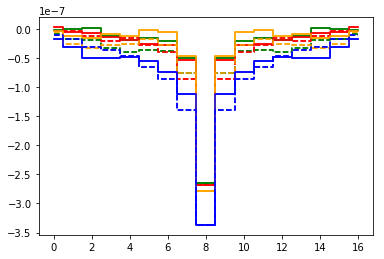

In [37]:
plt.plot(imsim_bf_kernel[0][:,8], color='green', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[0][8,:], color='green', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[1][:,8], color='red', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[1][8,:], color='red', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[2][:,8], color='orange', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[2][8,:], color='orange', linestyle='--', drawstyle='steps-mid')

plt.plot(imsim_bf_kernel[3][:,8], color='blue', drawstyle='steps-mid')
plt.plot(imsim_bf_kernel[3][8,:], color='blue', linestyle='--', drawstyle='steps-mid')

plt.show()

In [38]:
imsim_detector = 0  # We have 4.  Let's use this one when comparing below.

## HSC Brighter-Fatter Kernel
Calculated by Will Coulton  
Merlin Fisher-Levine has also calculated version.

This is the brighter-fatter kernel for CCD 41.  The HSC BF corrections were done based purely on the results from this CCD.

In [39]:
hsc_detector = 41
# hsc_bf_kernel_file = 'hsc_bfKernel-{:03d}.pkl'.format(hsc_detector)
hsc_bf_kernel_file = 'bf_kernels/HSC/hsc_brighter_fatter_kernel.pkl'
import pickle
with open(hsc_bf_kernel_file, 'rb') as f:
    hsc_bf_kernel = pickle.load(f, encoding='bytes')

# For the generic HSC BF kernel, stuff it into a dictionary so it looks like the other ones
hsc_bf_kernel = {hsc_detector: hsc_bf_kernel}

In [40]:
hsc_bf_radius = len(hsc_bf_kernel[hsc_detector])//2
r = np.arange(-hsc_bf_radius, +hsc_bf_radius+1)
plt.plot(r, hsc_bf_kernel[hsc_detector][:,hsc_bf_radius], color='red', drawstyle='steps-mid', label='HSC CCD 41 x')
plt.plot(r, hsc_bf_kernel[hsc_detector][hsc_bf_radius,:], color='red', linestyle='--', drawstyle='steps-mid', label='HSC CCD 41 y')
plt.xlabel('Distance from pixel')
plt.ylabel('Brighter-Fatter Kernel')

Text(0,0.5,'Brighter-Fatter Kernel')

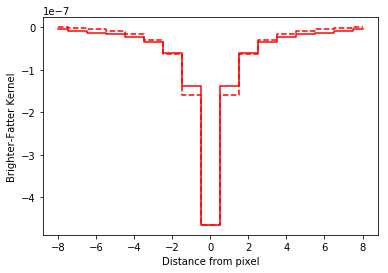

In [41]:
plt.show()

## Lab-based BF measurements

Let's compare this to lab-based ITL data from Craige Lage and Andrew Bradshaw.  I've taken the liberty of copying into this `DC2-production` repo the BF kernel they calculated from flats in the lab.

In [49]:
from astropy.io import fits
lab_bf_kernel = fits.getdata('bf_kernels/Lab/BF_kernel-ITL_3800C_002.fits')
# Make it look like the other ones
lab_detector = 2
lab_bf_kernel = {lab_detector: lab_bf_kernel}

In [50]:
# Create some dicts to simplify code below
ref_detectors = {'PhoSim': phosim_detector, 'ImSim': imsim_detector, 'HSC': hsc_detector, 'ITL': lab_detector}
bf_kernels = {'PhoSim': phosim_bf_kernel, 'ImSim': imsim_bf_kernel, 'HSC': hsc_bf_kernel, 'ITL': lab_bf_kernel}
colors = {'PhoSim': 'blue', 'ImSim': 'green', 'HSC': 'red', 'ITL': 'orange'}

In [51]:
bf_centers = {k: len(bf_kernels[k][ref_detectors[k]])//2 for k in bf_kernels}

In [52]:
for k, bf in bf_kernels.items():
    r = np.arange(-bf_centers[k], +bf_centers[k]+1)
    kernel_row = bf_kernels[k][ref_detectors[k]][:, bf_centers[k]]
    plt.plot(r, kernel_row,
             drawstyle='steps-mid', color=colors[k], label='{}'.format(k))

plt.legend()

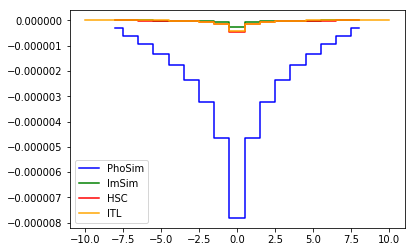

In [53]:
plt.show()

Hmmmm... are these just multiplicatively scaled versions?

Let's normalize to the central pixel.

In [54]:
central_values = {k: bf_kernels[k][ref_detectors[k]][bf_centers[k], bf_centers[k]] for k in bf_kernels}
ref_scale = 'ITL'
scale = {k: central_values[ref_scale]/central_values[k] for k in central_values}

# phosim_scale, imsim_scale, hsc_scale, lab_scale = 0.055, 1.6, 0.92, 1

In [55]:
print(central_values)
print(scale)

{'PhoSim': -7.809084644848518e-06, 'ImSim': -2.646821829757764e-07, 'HSC': -4.653174233407682e-07, 'ITL': -4.239152833351231e-07}
{'PhoSim': 0.05428488774478463, 'ImSim': 1.6016011299631743, 'HSC': 0.9110238776180001, 'ITL': 1.0}


In [56]:
for k, bf in bf_kernels.items():
    r = np.arange(-bf_centers[k], +bf_centers[k]+1)
    kernel_row = bf_kernels[k][ref_detectors[k]][:, bf_centers[k]]
    plt.plot(r, scale[k] * kernel_row,
             drawstyle='steps-mid', color=colors[k], label='{}'.format(k))

plt.legend()

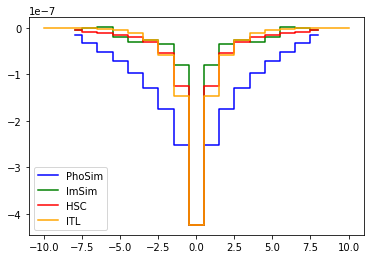

In [57]:
plt.show()

In [58]:
for k, bf in bf_kernels.items():
    r = np.arange(-bf_centers[k], +bf_centers[k]+1)
    kernel_row = bf_kernels[k][ref_detectors[k]][:, bf_centers[k]]
    plt.plot(r, - scale[k] * kernel_row,
             drawstyle='steps-mid', color=colors[k], label='{}'.format(k))

A = -central_values[ref_scale]
r0 = {'PhoSim': -6.5, 'ImSim': -1.8, 'HSC': -2.8, 'ITL': -2.8}
distance = np.linspace(-bf_centers[ref_scale], +bf_centers[ref_scale], 100)
for k, r in r0.items():
    plt.plot(distance, A*10**(-np.abs(distance/r)),
             color=colors[k], linestyle=':',
             label='{} r0={:.1f}'.format(k, r))

plt.ylim(1e-8, 1e-6)
plt.yscale('log')

plt.xlabel('Distance from pixel')
plt.ylabel('BF kernel value')

plt.legend()

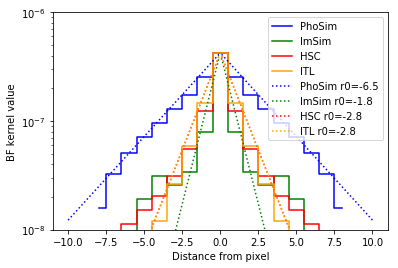

In [59]:
plt.show()

------
### Things to think about running sometime in the future

In [32]:
from lsst.pipe.drivers.constructCalibs import BiasTask
args_line = 'phosim_repo --rerun wmwv/calib --longlog --id visit=9999 --batch-type none --cores 4'
args = args_line.split(' ')
print(args)

### We're not actually going ton construct master bias or darks yet.
# BiasTask.parseAndSubmit(args=args)

['phosim_repo', '--rerun', 'wmwv/calib', '--longlog', '--id', 'visit=9999', '--batch-type', 'none', '--cores', '4']


In [33]:
# ! constructBias.py calib_repo --rerun wmwv/calib --longlog --id visit=9999 --batch-type none --cores 4

In [ ]:

## We don't have any master calibration images yet.
# ingestCalibs.py calib_repo --output calib_repo/CALIB --validity 13000 calib_repo/rerun/wmwv/calib/bias/2022-01-01/*.fits

# Darks next, before flats.
! ingestImages.py calib_repo dark_files/*.fits --mode link

# Make a master dark
! constructDark.py calib_repo --rerun wmwv/calib_dark --longlog --id visit=4000000 --batch-type none --cores 4

# Take the master dark we just created and load it into the CALIB_ROOT.
! ingestCalibs.py calib_repo --output calib_repo/CALIB --validity 13000 calib_repo/rerun/wmwv/calib_dark/dark/1994-07-19/*.fits

# Make a master flat.
! constructFlat.py calib_repo --rerun wmwv/calib_flat --longlog --id visit=219976 raft=R34 ccd=S02 --batch-type none

In [35]:
imsim_raw_glob = '/global/cscratch1/sd/jchiang8/desc/imsim_tests/bf_flats/lsst_a_*r.fits'
phosim_raw_glob = '/global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits'

mapper_str = 'lsst.obs.lsstCam.ImsimMapper'

Ingest the calibration files.

In [36]:
from lsst.pipe.tasks.ingest import IngestTask

# Do biases first since constructDark.py expects them.
arg_string = 'calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bias_files/*.fits --mode link'
args = ' '.split(arg_string)

# But this doesn't actually work because IngestImages only uses sys.argv.
# It doesn't accept an args passthrough to the `parseAndRun` method.
# IngestTask.parseAndRun(args=args)

In [ ]:
# So we call out to the shell with a !
### we don't even need bias or dark just to test out generation of the BF kernel.
# ! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bias_files/*.fits --mode link
# ! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/dark_files/*.fits --mode link
! ingestImages.py calib_repo /global/cscratch1/sd/jchiang8/desc/calibration_products/bf_flats/lsst_a*.fits --mode link